# Collaboration Network Node Classification

In [5]:
%cd /home/joel/repos/cscollab/backend

/home/joel/repos/cscollab/backend


In [11]:
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import kuzudb.query_kuzu as query
import collections
import torch
import torch_geometric
import torch_geometric.transforms as T
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
import functools


plt.style.use('default')
sns.set_style("whitegrid")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on', device)

Running on cuda


## Generate Dataset

First we create some mappings for the kuzudb data:
A mapping from the subarea id to the area id and a mapping of authors to their affiliated institution.
Further each reasearch area and subarea is onehot encoded and saved in a dictionary 

In [109]:

""" mapping of sub areas to areas"""
area_mapping = query.get_area_mapping()
subarea_mapping = dict(zip(area_mapping["sub-area-id"],area_mapping["area-id"]))

"""one hot encoding"""
onehot_encoder = OneHotEncoder(sparse_output=False)

area_ids = list(area_mapping["area-id"].unique())
n_area = len(area_ids)
onehot_encoded_areas = onehot_encoder.fit_transform(np.arange(n_area).reshape(n_area,1))
tensor_list_ohe_areas = list(map(lambda x: torch.tensor(x, dtype=torch.float), onehot_encoded_areas))
area_ohe_mapping = dict(zip(area_ids,tensor_list_ohe_areas))
area_binary_mapping = dict(zip(area_ids,[[0,0],[1,1],[1,0],[0,1]]))
print(area_ohe_mapping)

sub_area_ids = area_mapping["sub-area-id"].unique()
n_sub_area = len(sub_area_ids)
onehot_encoded_sub_areas = onehot_encoder.fit_transform(np.arange(n_sub_area).reshape(n_sub_area,1))
# tensor_list_ohe_sub_areas = list(map(lambda x: torch.tensor(x, dtype=torch.float), onehot_encoded_sub_areas))
sub_area_ohe_mapping = dict(zip(sub_area_ids,onehot_encoded_sub_areas))

"""mapping of author to institution"""
csauthors_all = query.get_csauthors()
author_inst_map = dict(zip(csauthors_all["pid"],csauthors_all["institution"]))

{'systems': tensor([1., 0., 0., 0.]), 'ai': tensor([0., 1., 0., 0.]), 'theory': tensor([0., 0., 1., 0.]), 'interdiscip': tensor([0., 0., 0., 1.])}


Given a collaboration network we want to get for each node (author or institution) what the frequency of publications in the different areas and sub areas are and in which sub/area the most publications. For this we define a function to count the frequency and a function to get the collaboration network based on a config

In [66]:
""" count the frequency of sub/areas for a node"""
def area_frequency_counter(collab, node):
    collab_node = collab[(collab["a"]==node) | (collab["b"]==node)]
    area_counter = dict(collections.Counter(collab_node["rec_area"]))
    top_area = max(area_counter, key=area_counter.get)
    sub_area_counter = dict(collections.Counter(collab_node["rec_sub_area"]))
    top_sub_area = max(sub_area_counter, key=sub_area_counter.get)
    freq= {"area_freq":area_counter,
            "top_area":top_area,
            "sub_area_freq":sub_area_counter,
            "top_sub_area":top_sub_area}
    return freq


def get_collab_data(config):
    """get collaboration"""
    collab = query.get_collaboration(config)  
    collab["rec_area"]=list(map(lambda x: subarea_mapping[x], collab["rec_sub_area"]))  
        
    if config.get("institution",False):
        collab["a"] = list(map(lambda x: author_inst_map[x], collab["a"].values))
        collab["b"] = list(map(lambda x: author_inst_map[x], collab["b"].values))


    """map each institution or author to an int based on the positional index"""
    nodes = list(set(collab["a"]).union(set(collab["b"])))
    node_idx = list(range(len(nodes)))
    node_idx_mapping = dict(zip(nodes, node_idx))

    frequency_map = dict(zip(node_idx, list(map(lambda n: area_frequency_counter(collab, n), nodes))))

    collab_weighted = query.get_weighted_collab(config)
    collab_weighted["a"] = list(map(lambda n: node_idx_mapping[n],collab_weighted["a"]))
    collab_weighted["b"] = list(map(lambda n: node_idx_mapping[n],collab_weighted["b"]))
    
    adjacency_list = list(map(list,zip(collab_weighted["a"], collab_weighted["b"])))
    weights = collab_weighted["weight"].values

    data = {"nodes": node_idx,
            "edges":adjacency_list,
            "weights":weights,
            "freq": frequency_map}
    return data

we define a config a check the collaboration network

In [67]:
"""define config as the collabortaion between institutions among Austria, Germany and Switzerland later than 2015"""
config = { "from_year": 2015,
            "region_id":"dach",
            "strict_boundary":True,
            "institution":True}

collab_data = get_collab_data(config)
print()
# Gather some statistics about the graph.
print(f'Number of first 10 nodes: {collab_data["nodes"][:10]}')
print(f'Number of first 10 edges: {collab_data["edges"][:10]}')
print(f'Number of first 10 weights: {collab_data["weights"][:10]}')
print(f'Frequency mapping of the first node: {collab_data["freq"][0]}')


Number of first 10 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of first 10 edges: [[59, 59], [78, 59], [77, 77], [1, 1], [13, 13], [5, 5], [66, 66], [38, 5], [59, 5], [12, 32]]
Number of first 10 weights: [88 81 76 74 73 69 53 48 42 38]
Frequency mapping of the first node: {'area_freq': {'interdiscip': 1, 'ai': 3, 'systems': 1}, 'top_area': 'ai', 'sub_area_freq': {'robotics': 1, 'ml': 3, 'networks': 1}, 'top_sub_area': 'ml'}


Next we create the torch data object:

* y is the onehot encoding of the research area with the most publications
* x is the percentage of published subareas calculated using the ohe of the subareas

In [111]:

"""get target label as the area with the most records published"""
def get_y(nodes, freq, method=0):
    top_areas = list(map(lambda x: freq[x]["top_area"], nodes))
    
    """get target label as torch tensor"""
    if method==0:
        """binary represnetation of y"""
        y = torch.tensor(list(map(lambda x: list(area_binary_mapping[x]),top_areas)),dtype=torch.float)
    elif method ==1: 
        """one hot endcoding representation of y"""
        y = torch.tensor(list(map(lambda x: list(area_ohe_mapping[x]),top_areas)),dtype=torch.float)
    elif method == 2:
        """int representation of y"""
        y = torch.tensor(list(map(lambda x: area_ids.index(x),top_areas)),dtype=torch.float)
    return y

def sub_area_frequency(freq,n):
    sfreq = freq[n]["sub_area_freq"]
    """sum up one hot endocings of the subareas by their frequency"""
    freq_array = functools.reduce(lambda x, key: x + sfreq[key] * sub_area_ohe_mapping[key], sfreq, np.zeros(n_sub_area))
    """get frequency as percentage such that it sums up to 1"""
    freq_array_p = freq_array/sum(sfreq.values())
    return freq_array_p 

"""the percentage of published subareas"""
def get_x(nodes,freq):
    x =  torch.tensor(np.array(list(map(lambda node: sub_area_frequency(freq,node) ,nodes))), dtype=torch.float)
    return x

def gen_torch_data(nodes,edges, freq, use_x=True ,weights=None, y_method=0,only_features=False):
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    y = get_y(nodes,freq,y_method)
    
    ohe = torch.eye(len(nodes))
    if use_x:
        if only_features:
            x=get_x(nodes, freq)
        else:
            x = torch.cat((get_x(nodes, freq), ohe), dim=1)
       
    else:
        x = ohe
    
    if weights is not None:
        weights = torch.tensor(weights,dtype=torch.long)
        
    """create torch data object without weights"""
    data = torch_geometric.data.Data(x=x, y=y, edge_index=edge_index, num_nodes=len(nodes))
    data = T.ToUndirected()(data) # the collaboration network is undirected
    data = T.AddSelfLoops()(data) # by adding self-loops, we ensure that aggregated messages from neighbors 
    data = T.NormalizeFeatures()(data) # features will sum up to 1
    """ define train test split"""
    transform = torch_geometric.transforms.RandomNodeSplit(split='train_rest', num_val=0.3, num_test=0)
    transform(data)
    return data

def collab_to_torch(config, weighted=False, use_x =True, y_method=0,only_features=False):
    collab_data = get_collab_data(config)
    nodes = collab_data["nodes"]
    edges = collab_data["edges"]
    weights = collab_data["weights"] if weighted else None
    freq = collab_data["freq"]
    data = gen_torch_data(nodes, edges, freq, use_x=use_x, weights=weights, y_method=y_method,only_features=only_features)
    return data

In [112]:
"""torch data object"""
data = collab_to_torch(config,only_features=True)
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
""" take a closer look at features"""
print(f'Features of first node: {data.x[0]}')
print(f'Sub area frequency of the first node: {collab_data["freq"][0]["sub_area_freq"]}')
print(f'Sum of ohe of the subfrquencies of the first node: {sub_area_ohe_mapping["robotics"] + 3*sub_area_ohe_mapping["ml"] + sub_area_ohe_mapping["networks"]}')

Data(x=[81, 23], edge_index=[2, 1129], y=[81, 2], num_nodes=81, train_mask=[81], val_mask=[81], test_mask=[81])
Number of nodes: 81
Number of edges: 1129
Number of features: 23
Number of training nodes: 57
Has isolated nodes: False
Has self-loops: True
Is undirected: True
Features of first node: tensor([0.0000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2000])
Sub area frequency of the first node: {'robotics': 1, 'ml': 3, 'networks': 1}
Sum of ohe of the subfrquencies of the first node: [0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Implement GNN

In [113]:
class GraphConvolution(torch_geometric.nn.MessagePassing):

    def __init__(self, in_ch, out_ch):
        super().__init__(aggr='add')

        # this linear function is used to transform node features 
        # into messages that are then "sent" to neighbors
        self.linear = torch.nn.Linear(in_ch, out_ch)
        
    def forward(self, x, edge_index):
        """
        This function uses the edges captured in edge_index, performs 
        the graph convolution function according to (Kipf, Welling 2017)
        and propagates the transformed features along the edges of the graph
        """

        # we linearly transform the features of *all* nodes stored in x
        x = self.linear(x)

        # extract source and target nodes of all edges
        source, target = edge_index
        
        # compute the (in-)degrees $d_i$ of source nodes
        deg = torch_geometric.utils.degree(target, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # with this, the normalization to be applied in the propagation step can be expressed as
        # this corresponds to D^{-0.5} A * D^{-0.5} in (Kipf, Welling 2017)
        norm = deg_inv_sqrt[source] * deg_inv_sqrt[target]
        
        # the propagate function propagates messages along the edges of the graph
        # this function internally calls the functions: message(), aggregate() and update()
        # the normalization is applied in the message() function
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        # x_j is a so-called **lifted** tensor which contains the source node features of each edge, 
        # i.e. it has a shape (m, out_ch) where m is the number of edges

        # a call to view(-1, 1) returns a reshaped tensor, where the second dimension 
        # is one and the first dimension is inferred automatically
        return norm.view(-1,1) * x_j



In [114]:
class GCN(torch.nn.Module):

    def __init__(self, data: torch_geometric.data.Data, out_ch, hidden_dim=16):
        super().__init__()

        # first convolution layer 
        self.input_to_hidden = GraphConvolution(data.num_node_features, hidden_dim)

        # second convolution layer
        self.hidden_to_output =  GraphConvolution(hidden_dim, out_ch)
        
    def forward(self, x, edge_index):
        
        # first graph convolution -> map nodes to representations in hidden_dim dimensions
        x = self.input_to_hidden(x, edge_index)

        # non-linear activation function
        x = torch.sigmoid(x)

        # second graph convolution -> maps node representations to output classes
        x = self.hidden_to_output(x, edge_index)

        # output class probabilities
        return torch.sigmoid(x)


In [115]:
data = collab_to_torch(config)
model = GCN(data, out_ch=2, hidden_dim=4)

epochs = 15000
lrn_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=lrn_rate)
print(model)

GCN(
  (input_to_hidden): GraphConvolution()
  (hidden_to_output): GraphConvolution()
)


Trainging of the model


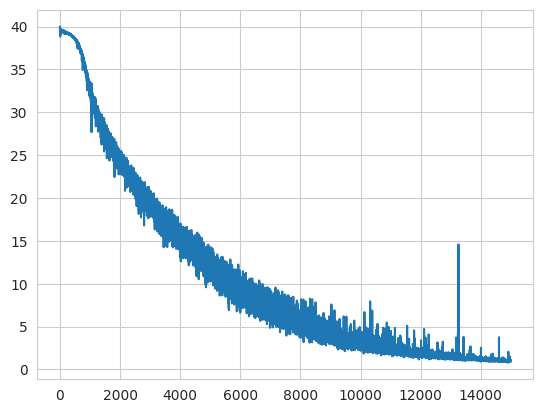

In [116]:
indices = np.arange(data.num_nodes)
losses = []
model.train()
for epoch in range(epochs):

    error = 0
    
    np.random.shuffle(indices)
    for i in indices:

        if data.train_mask[i]:

            # set gradients to zero
            optimizer.zero_grad()

            # compute loss function for training sample and backpropagate
            output = model(data.x, data.edge_index)
            loss = torch.nn.functional.binary_cross_entropy(output[i], data.y[i])
            loss.backward()

            # update parameters
            optimizer.step()

            error += loss.detach().numpy()

    losses.append(error)

# plot evolution of loss function
plt.plot(range(epochs), losses)

In [121]:
output = model.forward(data.x, data.edge_index)
# prediction = output
prediction = output.round().long()
# true_prediction = [data.y[x].argmax().item()==prediction[x].argmax().item() for x in range(data.num_nodes)]
true_prediction = np.array(prediction)==np.array(data.y)
true_prediction = np.logical_and(true_prediction[:,0],true_prediction[:,1])
accuracy=sum(true_prediction)/len(true_prediction)
print(accuracy)


0.8148148148148148


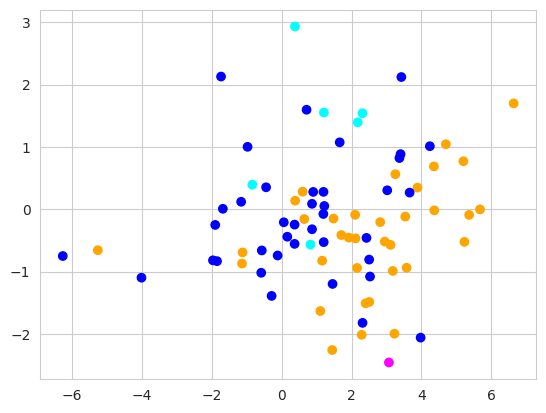

In [118]:
embedding = model.input_to_hidden.forward(data.x, data.edge_index)

svd = TruncatedSVD()
low_dim = svd.fit_transform(embedding.detach().numpy())

collab_data["freq"][0]
colors = {}
for n in range(data.num_nodes):
    top_area = collab_data["freq"][n]["top_area"] 
    idx = area_ids.index(top_area)
    if idx == 0:
        colors[n] = 'blue'
    elif idx == 1:
        colors[n] = 'orange'
    elif idx == 2:
        colors[n] = 'magenta'
    else:
        colors[n] = 'cyan'
plt.clf()
plt.scatter(low_dim[:,0], low_dim[:,1], c=colors.values())

# Try simple MLP model

In [122]:
from sklearn.manifold import TSNE
from torch.nn import Linear
import torch.nn.functional as F

data = collab_to_torch(config,only_features=True,y_method=2)
data.y = data.y.long()
print(data)

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, 4)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

Data(x=[81, 23], edge_index=[2, 1129], y=[81], num_nodes=81, train_mask=[81], val_mask=[81], test_mask=[81])


MLP(
  (lin1): Linear(in_features=23, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=4, bias=True)
)
Test Accuracy: 0.9136


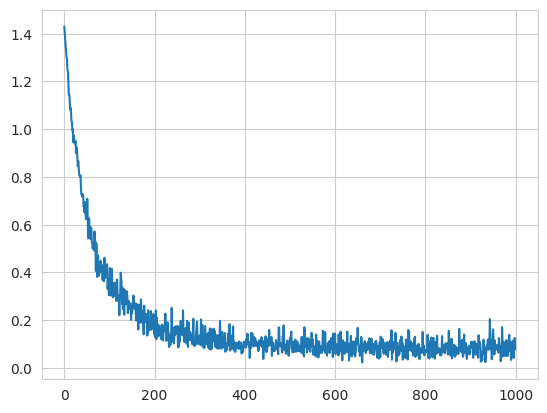

In [127]:
model = MLP(hidden_channels=16)
print(model)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)# Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[~data.test_mask] == data.y[~data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int((~data.test_mask).sum())  # Derive ratio of correct predictions.
      return test_acc

epochs= 1000
losses=[]
for epoch in range(epochs):
    loss = train()
    losses.append(loss.detach().numpy())

# plot evolution of loss function
plt.plot(range(epochs), losses)
    
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

In [128]:

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = torch_geometric.nn.GCNConv(data.num_features, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, 4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(23, 16)
  (conv2): GCNConv(16, 4)
)


In [131]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

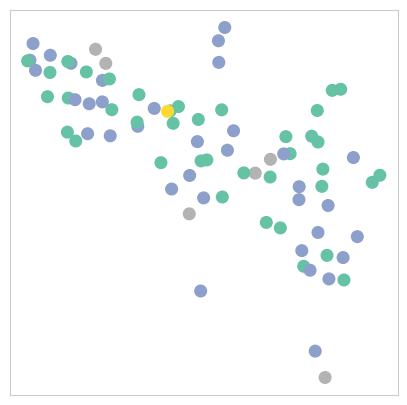

In [132]:
model = GCN(hidden_channels=16)
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Test Accuracy: 0.7037


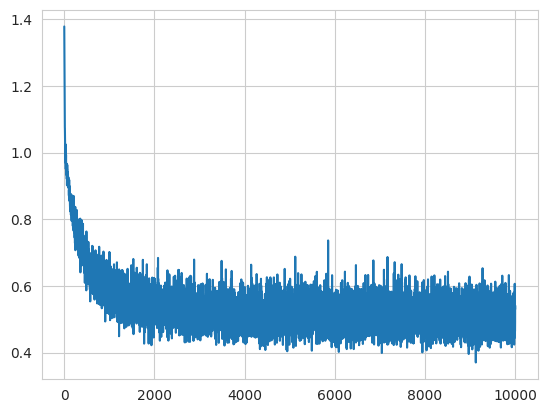

In [134]:

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[~data.test_mask] == data.y[~data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int((~data.test_mask).sum())  # Derive ratio of correct predictions.
      return test_acc


epochs= 10000
losses=[]
for epoch in range(epochs):
    loss = train()
    losses.append(loss.detach().numpy())

# plot evolution of loss function
plt.plot(range(epochs), losses)
    
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

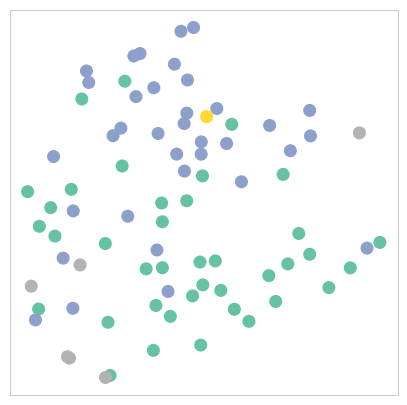

In [135]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)